In [1]:
import numpy as np
import pandas as pd 
from keras.preprocessing.image import ImageDataGenerator, load_img
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt
import seaborn as sns
import random
import shutil
import os
import re
import glob
import keras
import tensorflow as tf

FAST_RUN = False
IMAGE_WIDTH = 150
IMAGE_HEIGHT = 150
IMAGE_SIZE = (IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNELS = 3

print(os.listdir("../input"))
print(os.listdir("/kaggle/working/"))
print(tf.__version__)

['bee-vs-wasp', 'resnet50']
['__notebook_source__.ipynb']
2.4.1


## Collect and parse data
---

In [2]:
main_dir = "../input/bee-vs-wasp/kaggle_bee_vs_wasp"
categories = []
fname = []
ctr = 0
    
# collect 2000 bee images
for filename in random.sample(glob.glob(main_dir + '/bee1/*'), 2000):
    fname.append(filename)
    categories.append('bee')

# collect 2000 wasp images
for filename in random.sample(glob.glob(main_dir + '/wasp1/*'), 2000):
    fname.append(filename)
    categories.append('wasp')
    

df = pd.DataFrame({
    'filename': fname,
    'category': categories
})

df.sample(5)

,filename,category
3467,../input/bee-vs-wasp/kaggle_bee_vs_wasp/wasp1/...,wasp
39,../input/bee-vs-wasp/kaggle_bee_vs_wasp/bee1/1...,bee
2648,../input/bee-vs-wasp/kaggle_bee_vs_wasp/wasp1/...,wasp
3787,../input/bee-vs-wasp/kaggle_bee_vs_wasp/wasp1/...,wasp
1380,../input/bee-vs-wasp/kaggle_bee_vs_wasp/bee1/4...,bee


## Data exploration
---

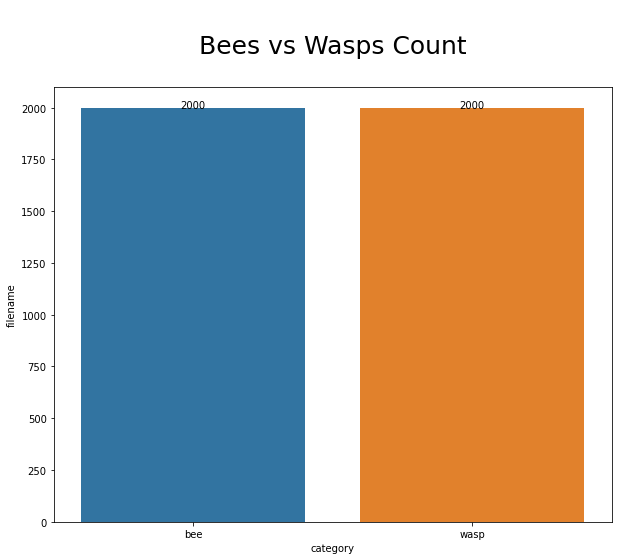

In [3]:
# plt.style.use('fivethirtyeight')
plt.figure(figsize=(10,8))

df_2 = df.groupby('category').count()
df_2.reset_index(inplace=True)
ax = sns.barplot(x='category', y='filename', data=df_2);
ax.set_title('\nBees vs Wasps Count\n', fontsize=25)

values = df['category'].value_counts()

for i, p in enumerate(ax.patches):
    height = p.get_height()
    ax.text(p.get_x() + p.get_width() / 2, height, values[i], ha="center")

## Perform train test split on main dataframe
---

In [4]:
X = df.drop(['category'], axis=1)

# split training_set data into training, validation, and test numpy arrays
X_train, X_val, y_train, y_val = train_test_split(X, df['category'], train_size=0.2, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# init dataframes
train_df = pd.DataFrame(data=X_train.astype('string'))
train_df['category'] = y_train.astype('string')
valid_df = pd.DataFrame(data=X_val.astype('string'))
valid_df['category'] = y_val.astype('string')
test_df = pd.DataFrame(data=X_test.astype('string'))
test_df['category'] = y_test.astype('string')

print(f'X_train = {X_train.shape}')
print(f'y_train = {y_train.shape}')
print(f'X_val = {X_val.shape}')
print(f'y_val = {y_val.shape}')
print(f'X_test = {X_test.shape}')
print(f'y_test = {y_test.shape}')

X_train = (640, 1)
y_train = (640,)
X_val = (3200, 1)
y_val = (3200,)
X_test = (160, 1)
y_test = (160,)


In [5]:
test_df

,filename,category
201,../input/bee-vs-wasp/kaggle_bee_vs_wasp/bee1/2...,bee
2568,../input/bee-vs-wasp/kaggle_bee_vs_wasp/wasp1/...,wasp
2938,../input/bee-vs-wasp/kaggle_bee_vs_wasp/wasp1/...,wasp
3457,../input/bee-vs-wasp/kaggle_bee_vs_wasp/wasp1/...,wasp
3280,../input/bee-vs-wasp/kaggle_bee_vs_wasp/wasp1/...,wasp
...,...,...
3314,../input/bee-vs-wasp/kaggle_bee_vs_wasp/wasp1/...,wasp
3507,../input/bee-vs-wasp/kaggle_bee_vs_wasp/wasp1/...,wasp
1267,../input/bee-vs-wasp/kaggle_bee_vs_wasp/bee1/4...,bee
3878,../input/bee-vs-wasp/kaggle_bee_vs_wasp/wasp1/...,wasp


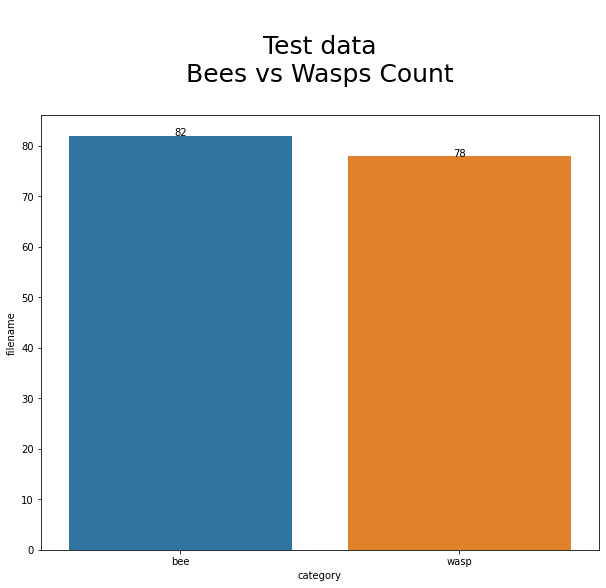

In [6]:
plt.figure(figsize=(10,8))

df_2 = test_df.groupby('category').count()
df_2.reset_index(inplace=True)
ax = sns.barplot(x='category', y='filename', data=df_2);
ax.set_title('\nTest data\nBees vs Wasps Count\n', fontsize=25)

values = test_df['category'].value_counts()

for i, p in enumerate(ax.patches):
    height = p.get_height()
    ax.text(p.get_x() + p.get_width() / 2, height, values[i], ha="center")

## Preprocess image data
---

In [7]:
import tensorflow.keras.preprocessing.image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.applications.resnet50 import preprocess_input

batch_size = 10

base_datagen = ImageDataGenerator(rescale=1./255)

datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

sample_generator = base_datagen.flow_from_dataframe(
    train_df, 
    None, 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='binary',
    batch_size=batch_size
)

train_generator = datagen.flow_from_dataframe(
    train_df, 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='binary',
    batch_size=batch_size
)

valid_generator = datagen.flow_from_dataframe(
    valid_df, 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='binary',
    batch_size=batch_size
)

test_generator = base_datagen.flow_from_dataframe(
    test_df,
    target_size=IMAGE_SIZE,
    class_mode=None,
    batch_size=1,
    shuffle=False,
    seed=42
)

Found 640 validated image filenames belonging to 2 classes.
Found 640 validated image filenames belonging to 2 classes.
Found 3200 validated image filenames belonging to 2 classes.
Found 160 validated image filenames.


## Data visualization
---

In [8]:
sample_generator.class_indices

{'bee': 0, 'wasp': 1}

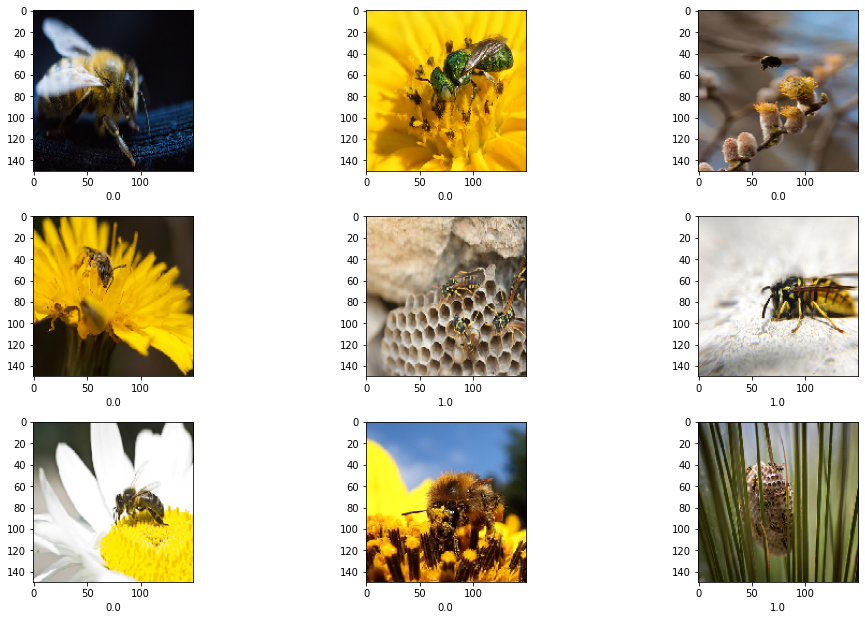

In [9]:
# plot 9 randomly selected regular training files

plt.figure(figsize=(14, 14))

for i in range(0, 9):
    plt.subplot(5, 3, i+1)
    x, y = sample_generator.next()
    image = x[i]
    label = y[i]
    plt.imshow(image)
    plt.xlabel(label)
        
plt.tight_layout()
plt.show()

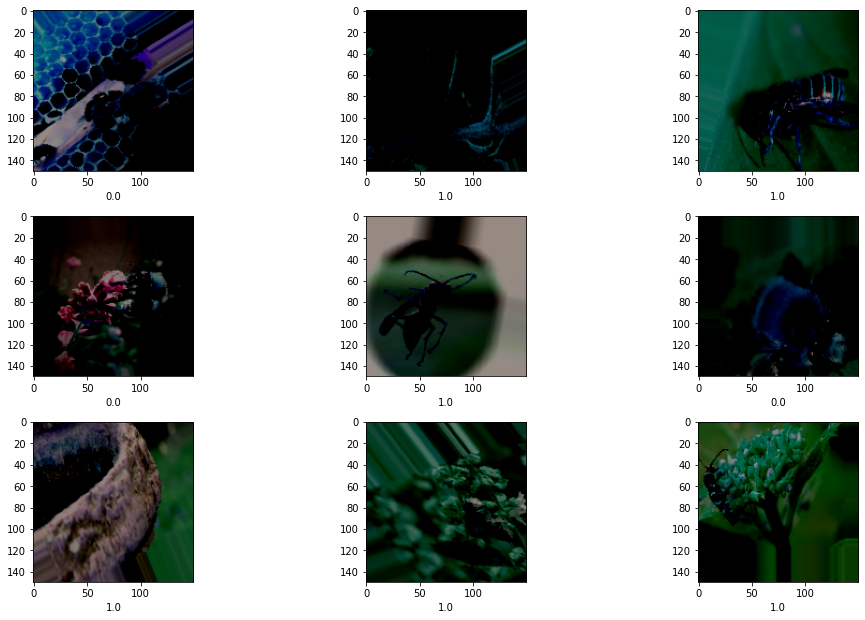

In [10]:
# plot 9 randomly selected augmented training files

plt.figure(figsize=(14, 14))

for i in range(0, 9):
    plt.subplot(5, 3, i+1)
    for X_batch, Y_batch in train_generator:
        image = X_batch[i]
        label = Y_batch[i]
        plt.imshow(image)
        plt.xlabel(label)
        break
        
plt.tight_layout()
plt.show()

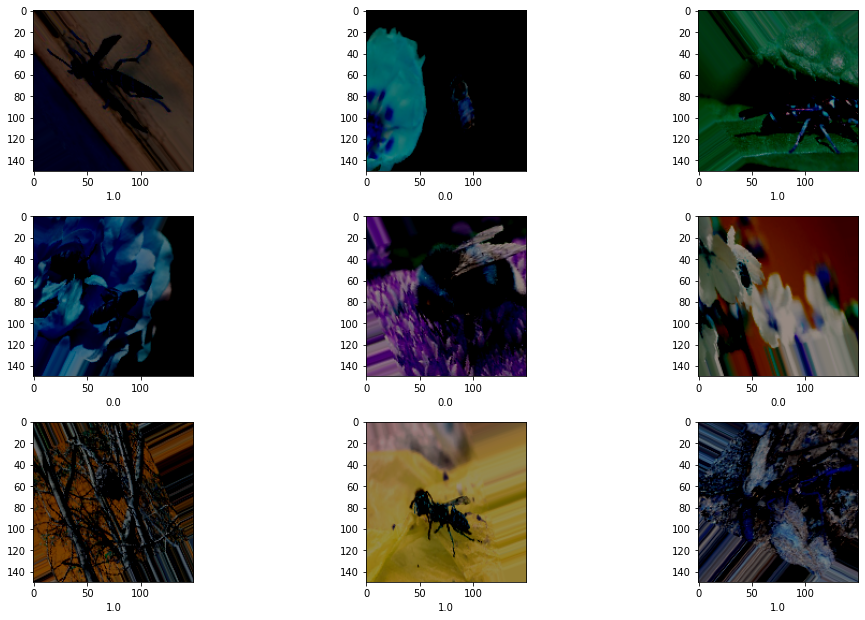

In [11]:
# plot 9 randomly selected validation files

plt.figure(figsize=(14, 14))
for i in range(0, 9):
    plt.subplot(5, 3, i+1)
    for X_batch, Y_batch in valid_generator:
        image = X_batch[i]
        label = Y_batch[i]
        plt.imshow(image)
        plt.xlabel(label)
        break
        
plt.tight_layout()
plt.show()

## Build and compile sequential model
---

In [102]:
from tensorflow.keras.optimizers import RMSprop

model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(
    loss='binary_crossentropy',
    optimizer=RMSprop(lr=1e-4),
    metrics=['binary_accuracy']
)
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 15, 15, 128)      

## Initialize callbacks
---

In [43]:
from keras.callbacks import ModelCheckpoint

earlystop = EarlyStopping(patience=5)

model_path = '/kaggle/working/bees_wasps_model.h5'
checkpoint = ModelCheckpoint(model_path, monitor='val_binary_accuracy', verbose=1, save_best_only=True, mode='max')

learning_rate_reduction = ReduceLROnPlateau(
    monitor="val_binary_accuracy", 
    factor=0.5,
    patience=5, 
    verbose=1
)

callbacks = [checkpoint]

## Train sequential model
---

In [44]:
epochs = 100
total_train = train_df.shape[0]
total_valid = valid_df.shape[0]

print(f'Total training data = {total_train}')
print(f'Total validation data = {total_valid}\n')

v_steps = total_valid // batch_size
e_steps = total_train // batch_size

with tf.device('/gpu:0'):
    history = model.fit(
        train_generator, 
        epochs=epochs,
        validation_data=valid_generator,
        validation_steps=v_steps,
        steps_per_epoch=e_steps,
        callbacks=callbacks,
        use_multiprocessing=False
    )

Total training data = 640
Total validation data = 3200

Epoch 1/100
64/64 [==============================] - 26s 399ms/step - loss: 0.6956 - binary_accuracy: 0.4929 - val_loss: 0.6851 - val_binary_accuracy: 0.5075

Epoch 00001: val_binary_accuracy improved from -inf to 0.50750, saving model to /kaggle/working/bees_wasps_model.h5
Epoch 2/100
64/64 [==============================] - 25s 389ms/step - loss: 0.6627 - binary_accuracy: 0.6026 - val_loss: 0.6189 - val_binary_accuracy: 0.6569

Epoch 00002: val_binary_accuracy improved from 0.50750 to 0.65688, saving model to /kaggle/working/bees_wasps_model.h5
Epoch 3/100
64/64 [==============================] - 25s 397ms/step - loss: 0.6139 - binary_accuracy: 0.6774 - val_loss: 0.6661 - val_binary_accuracy: 0.5744

Epoch 00003: val_binary_accuracy did not improve from 0.65688
Epoch 4/100
64/64 [==============================] - 25s 392ms/step - loss: 0.6150 - binary_accuracy: 0.6969 - val_loss: 0.5596 - val_binary_accuracy: 0.7212

Epoch 00004

In [45]:
train_data = model.evaluate(train_generator, verbose=1)
valid_data = model.evaluate(valid_generator, verbose=1)

print(f'\nTraining loss value & metrics values: {train_data}')
print(f'Validation loss value & metrics values: {valid_data}\n')

320/320 [==============================] - 22s 67ms/step - loss: 0.4388 - binary_accuracy: 0.8256

Training loss value & metrics values: [0.21691012382507324, 0.9078124761581421]
Validation loss value & metrics values: [0.4387860596179962, 0.8256250023841858]



## Plot model's performance metrics during training
---

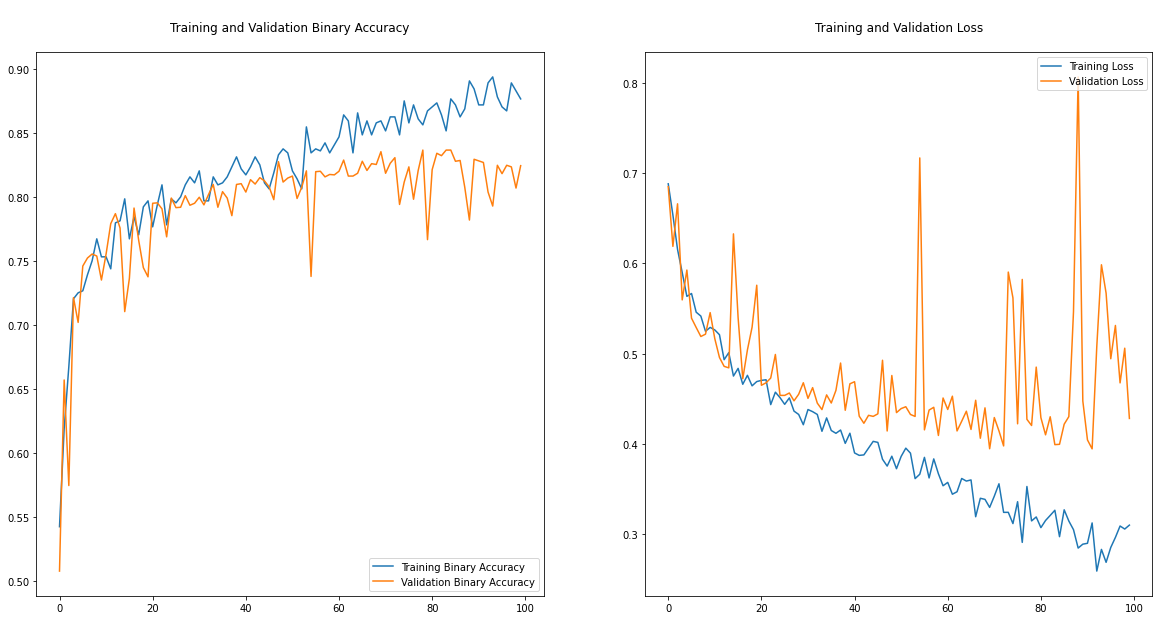

In [103]:
acc = history.history['binary_accuracy']
val_acc = history.history['val_binary_accuracy']

loss=history.history['loss']
val_loss=history.history['val_loss']

plt.figure(figsize=(20, 10))
plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Binary Accuracy')
plt.plot(val_acc, label='Validation Binary Accuracy')
plt.legend(loc='lower right')
plt.title('\nTraining and Validation Binary Accuracy\n')

plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('\nTraining and Validation Loss\n')
plt.show()

## Perform inference and verify results
---

In [48]:
train_generator.class_indices

{'bee': 0, 'wasp': 1}

## Perform predictions on test data and evaluate model
---

In [70]:
best_model = keras.models.load_model(model_path)
pred_lst = []
test_generator.reset()

with tf.device('/gpu:0'):
    predictions = best_model.predict(test_generator, verbose=1)
    
for i in predictions:
    preds = "wasp" if i * 100 > 50 else "bee"
    pred_lst.append(preds)

160/160 [==============================] - 1s 4ms/step



Test Accuracy = 66.8750
Test Precision Score = 80.7692
Test Recall Score = 62.3762



Text(0.5, 257.44, '\nPredicted label\n')

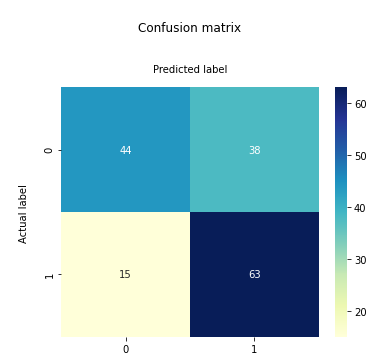

In [99]:
from sklearn import metrics

test_accuracy = metrics.accuracy_score(pred_lst, test_df['category'])

print(f'\nTest Accuracy = {test_accuracy * 100:.4f}')
print(f"Test Precision Score = {metrics.precision_score(pred_lst, test_df['category'], average='binary', pos_label='wasp') * 100:.4f}")
print(f"Test Recall Score = {metrics.recall_score(pred_lst, test_df['category'], average='binary', pos_label='wasp') * 100:.4f}\n")

# create heatmap
fig, ax = plt.subplots(figsize=(5, 4))
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu", fmt='g')
ax.xaxis.set_label_position("top")

plt.tight_layout()
plt.title('\nConfusion matrix\n')
plt.ylabel('\nActual label\n')
plt.xlabel('\nPredicted label\n')

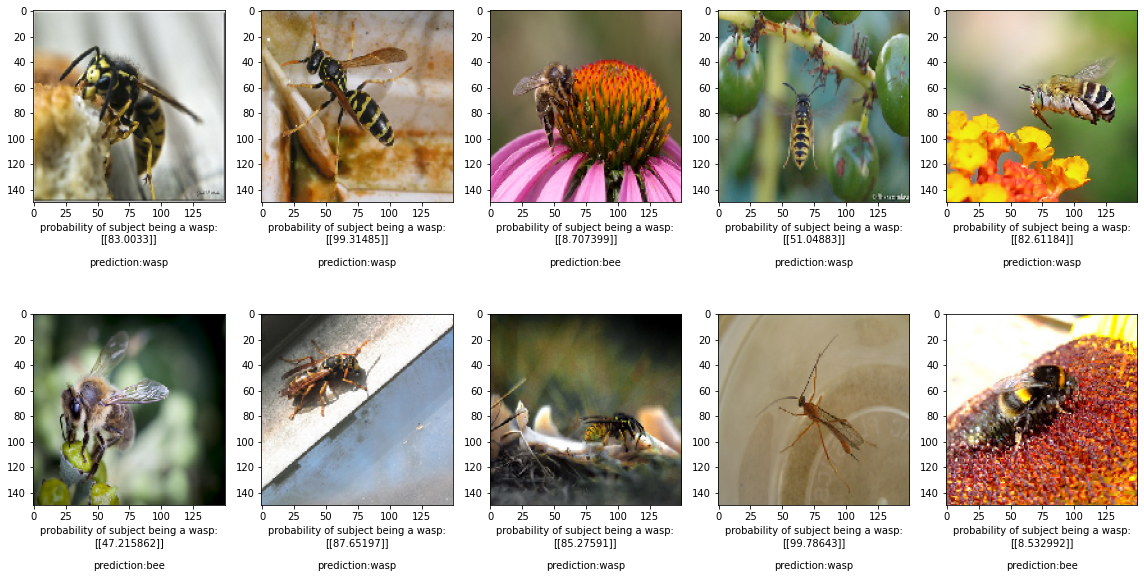

In [101]:
import random
from keras.preprocessing import image

best_model = keras.models.load_model(model_path)

plt.figure(figsize=(16, 9))

test_generator.reset()

for i in range(0, 10):
    plt.subplot(2, 5, i+1)
    
    x = test_generator.next()
    test_image = x[0]
    preds = best_model.predict(x)
    
    pred = "wasp" if preds * 100 > 50 else "bee"
    label = f'probability of subject being a wasp:\n{preds*100}\n\nprediction:{pred}'
    
    plt.imshow(test_image)
    plt.xlabel(label)
        
plt.tight_layout()
plt.show()

## Plot validation data predictions
---

In [52]:
best_model = keras.models.load_model(model_path)
valid_generator.reset()

with tf.device('/gpu:0'):
    predictions = best_model.predict(valid_generator, verbose=1) 
    print(predictions[:10])

320/320 [==============================] - 21s 66ms/step
[[0.05297169]
 [0.98442256]
 [0.5063279 ]
 [0.07634337]
 [0.00500663]
 [0.02868732]
 [0.00612139]
 [0.902584  ]
 [0.97613984]
 [0.01421102]]


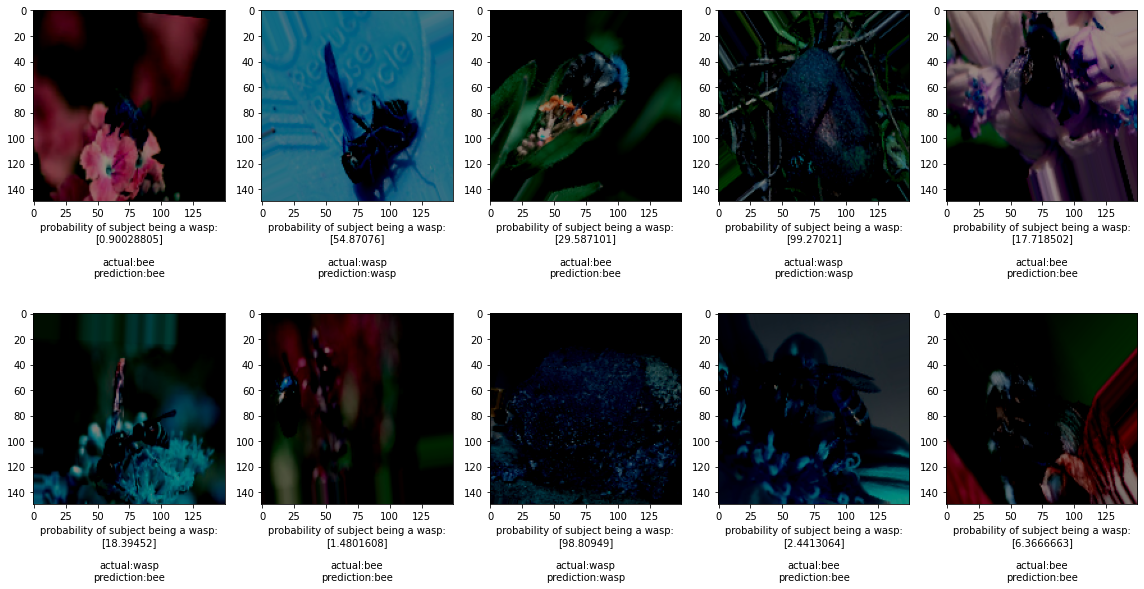

In [53]:
from keras.preprocessing import image

best_model = keras.models.load_model(model_path)

plt.figure(figsize=(16, 9))

test_generator.reset()

for i in range(0, 10):
    plt.subplot(2, 5, i+1)
    
    x, y = valid_generator.next()
    test_image = x[i]
    preds = best_model.predict(x)
    
    pred = "wasp" if preds[i] * 100 > 50 else "bee"
    actual = "wasp" if y[i] else "bee"
    label = f'probability of subject being a wasp:\n{preds[i]*100}\n\nactual:{actual}\nprediction:{pred}'
    
    plt.imshow(test_image)
    plt.xlabel(label)
        
plt.tight_layout()
plt.show()

## Plot sample data predictions
---

In [54]:
best_model = keras.models.load_model(model_path)
sample_generator.reset()

with tf.device('/gpu:0'):
    predictions = best_model.predict(sample_generator, verbose=1) 
    print(predictions[:10])

64/64 [==============================] - 2s 28ms/step
[[0.9581519 ]
 [0.5474314 ]
 [0.2703198 ]
 [0.962131  ]
 [0.2076633 ]
 [0.98679996]
 [0.00242375]
 [0.9407275 ]
 [0.9737941 ]
 [0.21784149]]


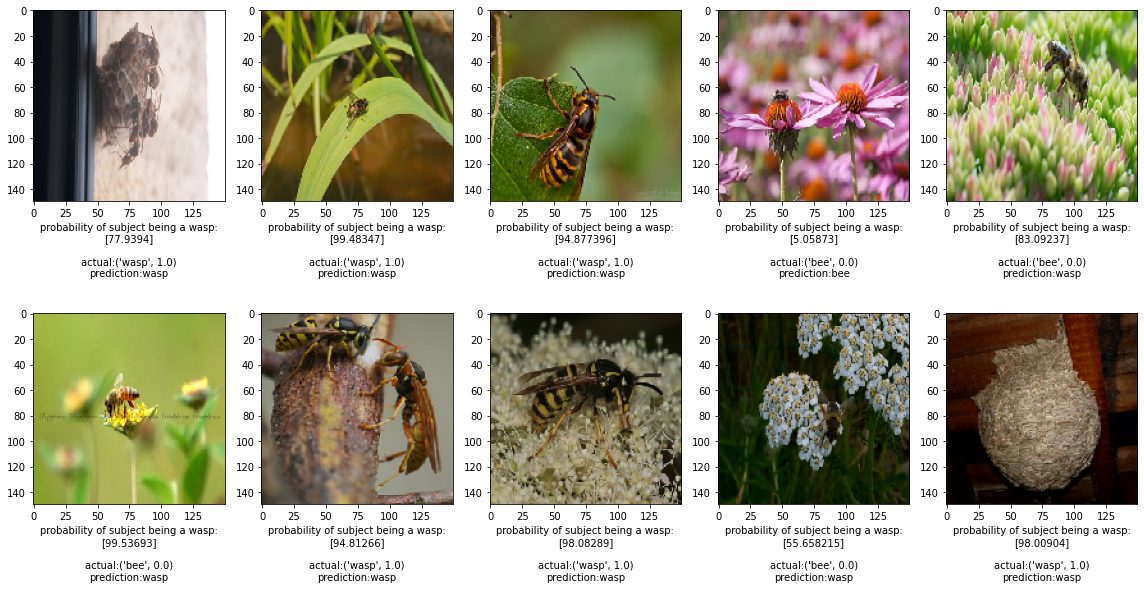

In [55]:
from keras.preprocessing import image

best_model = keras.models.load_model(model_path)

plt.figure(figsize=(16, 9))

test_generator.reset()

for i in range(0, 10):
    plt.subplot(2, 5, i+1)
    
    x, y = sample_generator.next()
    test_image = x[i]
    preds = best_model.predict(x)
    
    pred = "wasp" if preds[i] * 100 > 50 else "bee"
    actual = "wasp" if y[i] else "bee"
    label = f'probability of subject being a wasp:\n{preds[i]*100}\n\nactual:{actual, y[i]}\nprediction:{pred}'
    
    plt.imshow(test_image)
    plt.xlabel(label)
        
plt.tight_layout()
plt.show()